In [1093]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from collections import defaultdict

In [1094]:
def plot(im, size = (12,12), cbar=False, cmap="viridis"):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(im, interpolation='nearest', cmap=cmap)
    plt.tight_layout()
    if cbar:
        fig.colorbar(im, ax = ax)

#### Step 1) Start with an image.	


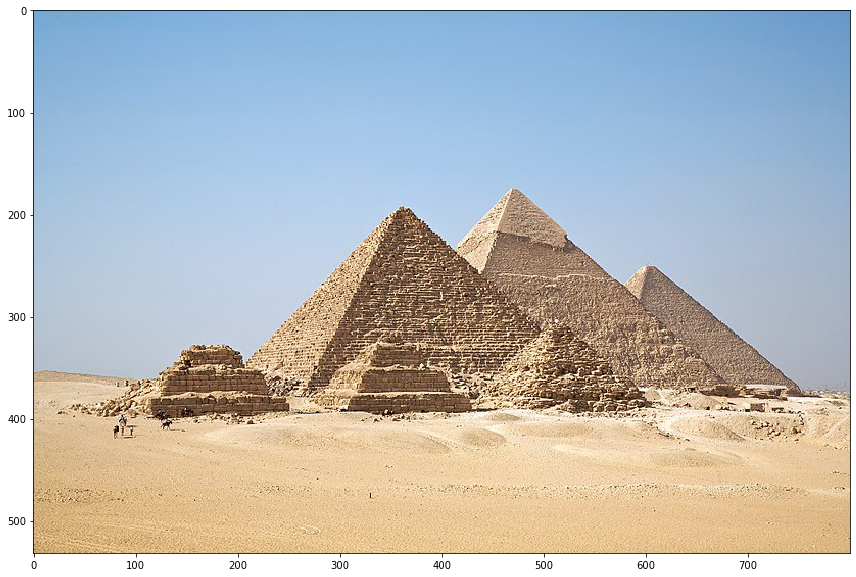

In [1095]:
# im = plt.imread("images/BroadwayTowerSeamCarvingA.png")
im = Image.open("images/windmills.png")
im_gray = np.asarray(im.convert("L"))
im = np.asarray(im)
plot(im)

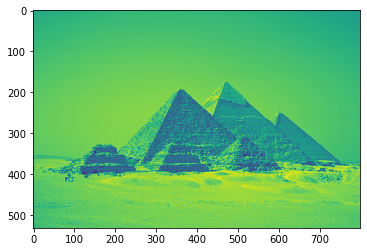

In [1096]:
plt.imshow(im_gray)

In [1097]:
def conv2d(img, krn):
    """
    Compute 2d convolution, stolen from stackoverflow
    """
    is0, is1, ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1
    
    ix0 = np.arange(ks0)[:, None] + np.arange(rs0)[None, :]
    ix1 = np.arange(ks1)[:, None] + np.arange(rs1)[None, :]
    
    res = krn[:, None, :, None] * img[(ix0.ravel()[:, None], ix1.ravel()[None, :])].reshape(ks0, rs0, ks1, rs1)
    res = res.transpose(1, 3, 0, 2).reshape(rs0, rs1, -1).sum(axis = -1)
    
    return res

In [1098]:
def gradient_magnitude(a: np.ndarray) -> np.ndarray:
    """
    Computes the gradient magnitude. Not very fast but ok
    See: https://pyimagesearch.com/2021/05/12/image-gradients-with-opencv-sobel-and-scharr/
    """
    b = np.ones((a.shape[0] - 2, a.shape[1] - 2))

    for y in range(1, a.shape[1]-1):
        for x in range(1, a.shape[0]-1):
            gx = int(a[x - 1, y]) - int(a[x + 1, y])
            gy = int(a[x, y - 1]) - int(a[x, y + 1])
            g = np.sqrt(gx ** 2 + gy ** 2)
            b[x - 1, y - 1] = g

    return b

#### Step 2) Calculate the weight/density/energy of each pixel. 
This can be done by various algorithms: gradient magnitude, entropy, visual saliency, eye-gaze movement.[1] Here we use gradient magnitude.

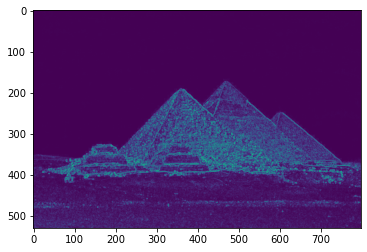

In [1099]:
im_grad = gradient_magnitude(im_gray)
plt.imshow(im_grad)
plt.show()

In [1100]:
# Shink image by 2 to account for padding in gradient
im_gray = im_gray[1:-1,1:-1]
im = im[1:-1,1:-1]

#### Step 3) From the energy, make a list of seams. Seams are ranked by energy, with low energy seams being of least importance to the content of the image. 
Seams can be calculated via the dynamic programming approach below.

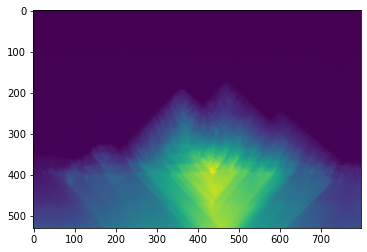

In [1101]:
direction = 0 # Vertical
bi_direction = (direction+1) % 2

cumm = np.copy(im_grad)

for i in range(1, im_grad.shape[direction]):
    for j in range(0, im_grad.shape[bi_direction]):
        offset_left = 0 if j == 0 else 1
        cumm[i,j] = np.min(cumm[i-1,j-offset_left:j+2]) + im_grad[i,j]

plt.imshow(cumm)

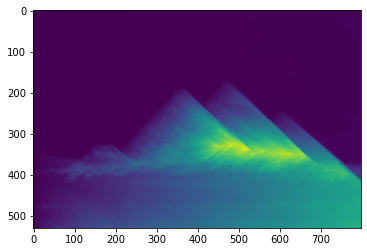

In [1102]:
direction = 1
bi_direction = (direction+1) % 2

cumm = np.copy(im_grad)

for i in range(1, im_grad.shape[direction]):
    for j in range(0, im_grad.shape[bi_direction]):
        offset_left = 0 if j == 0 else 1
        cumm[j,i] = np.min(cumm[j-offset_left:j+2, i-1]) + im_grad[j,i]

plt.imshow(cumm)

In [1103]:
def cumulative_min_energy(im, vertically = True):
    """ Calculates the cumulative energy in an image either horizontally or vertically """
    cumm = np.copy(im)

    for i in range(1, im.shape[not vertically]):
        for j in range(0, im.shape[vertically]):
            offset = 0 if j == 0 else 1
            if vertically:
                cumm[i,j] = np.min(cumm[i-1,j-offset:j+2]) + im_grad[i,j]
            else:
                cumm[j,i] = np.min(cumm[j-offset:j+2, i-1]) + im_grad[j,i]
    
    return cumm

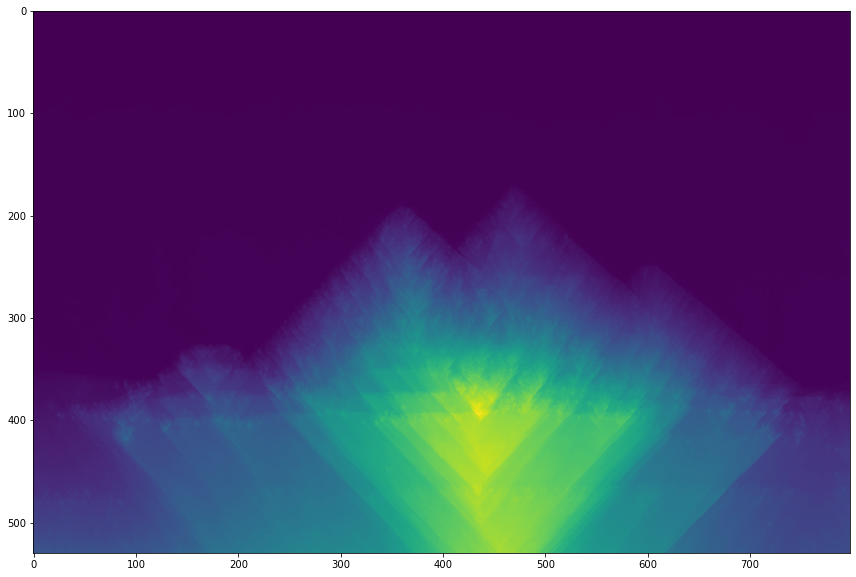

In [1104]:
cumm = cumulative_min_energy(im_grad, vertically = True)

plot(cumm)

In [1105]:
max_seams = 100

h, w = cumm.shape

seams = []

positions_filled = defaultdict(set)

for k in range(max_seams):

    start_index = np.argsort(cumm[-1,:])[k]
    
    seam = [start_index]
    cumm[h-1, start_index] = 10000

    positions_filled[h-1].add(start_index)

    for i in range(h-1, 0, -1):
        
        current = seam[-1]
        
        # offset = 0 if i == 0 else 1

        best_option = np.Inf
        best_option_index = None

        for opt in range(current-1, current+2):
            
            # print(current, [i for i in range(current-1, current+2)], opt, i-1, cumm[i-1, opt], best_option, best_option_index)

            if (opt < 0) or (w - 1 < opt) or (opt in positions_filled[i-1]):
                continue
        
            if cumm[i-1, opt] < best_option:
                best_option = cumm[i-1, opt]
                best_option_index = opt
                
        if best_option_index == None:
            best_option_index = current

        positions_filled[i-1].add(best_option_index)
        seam.append(best_option_index)
        cumm[i-1, best_option_index] = 10000
        # im_gray[i-1, best_option_index] = 10000
    
    seams.append(seam)


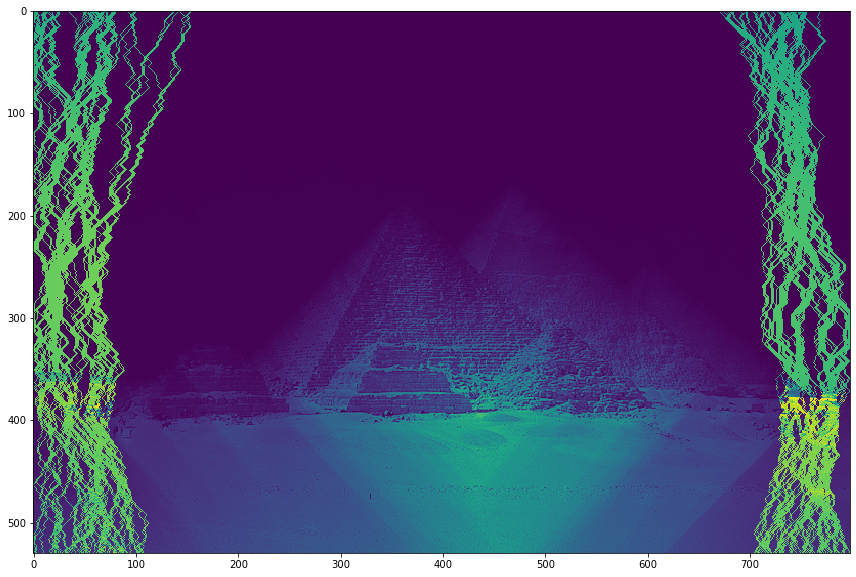

In [1106]:
plot(cumm * im_gray)

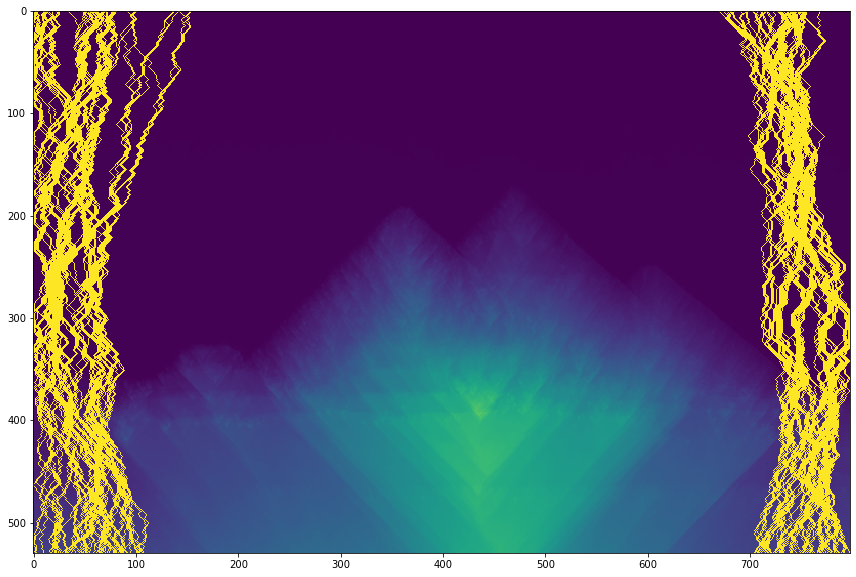

In [1107]:
plot(cumm)

### Step 4) Remove low-energy seams as needed.	

In [1108]:
threshold = 0.20 # percent 
seams = np.array(seams)

mask = [threshold < ((seams == i).sum() / w) for i in range(w)]

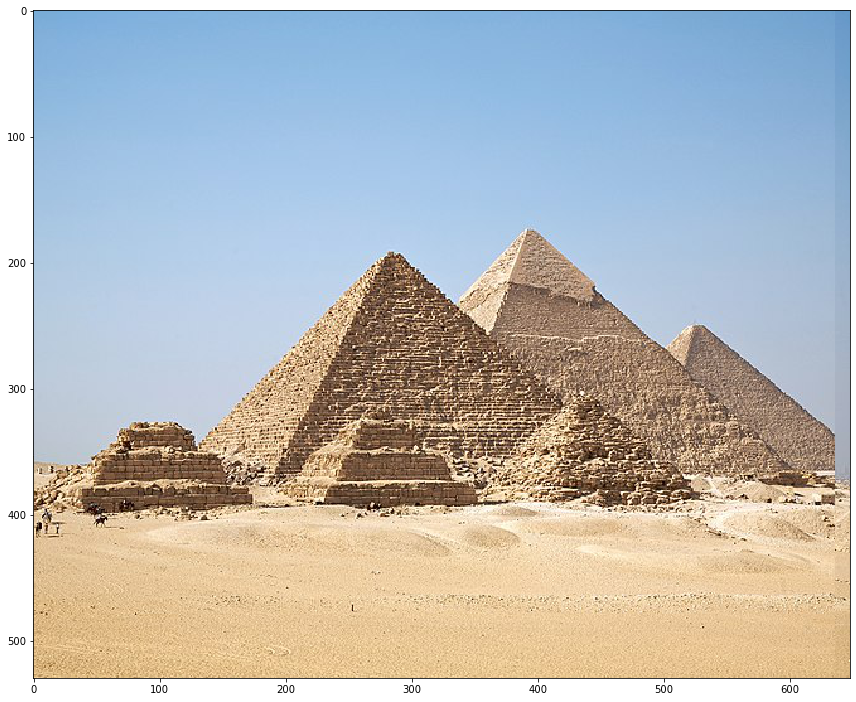

In [1109]:
plot(np.delete(im, mask, axis=1))

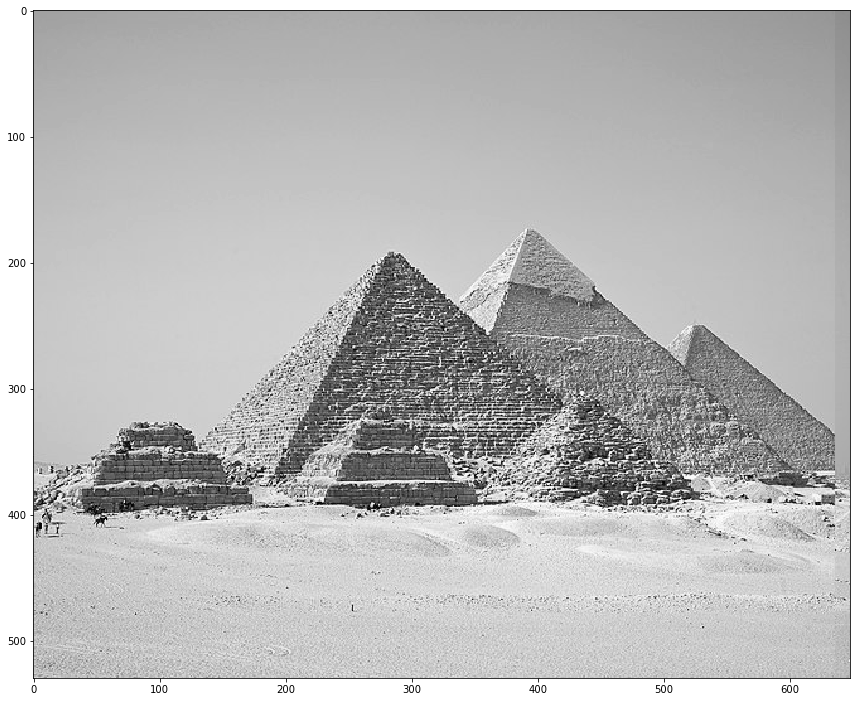

In [1110]:
plot(np.delete(im_gray, mask, axis=1), cmap="gray")

In [1111]:
# from collections import defaultdict

# max_seams = 30

# h, w = cumm.shape

# seams = []

# positions_filled = defaultdict(set)

# for k in range(max_seams):

#     start_index = np.argsort(cumm[-1,:])[k]
    
#     seam = [start_index]
#     cumm[h-1, start_index] = 10000

#     positions_filled[h].add(start_index)

#     for i in range(h-2, -1, -1):
        
#         prev = seam[-1]
        
#         offset = 0 if i == 0 else 1

#         best_option = np.Inf
#         best_option_index = None

#         for opt in range(prev-offset, prev+2):
            
#             if (opt < 0) or (w - 1 < opt) or (opt in positions_filled[i-1]):
#                 continue
#             if cumm[i-1, opt] < best_option:
#                 best_option = cumm[i-1, opt]
#                 best_option_index = opt
                
#         if best_option_index == None:
#             continue

#         positions_filled[i-1].add(best_option_index)
#         seam.append(best_option_index)
#         cumm[i, best_option_index] = 10000
    
#     seams.append(seam)
